In [1]:
# loads npm dataset and calculates transitivity reach for each package
# transitivity reach = total number of packages that depend (directly or indirectly) on it
# saves the ranked results as a csv file

In [5]:

import pandas as pd
from ast import literal_eval
from collections import defaultdict, deque

# load the csv
df = pd.read_csv("top_5000_npm_packages.csv")

# turn text into a python list
def safe_parse(x):
    try:
        if pd.isna(x) or x == "[]":
            return []
        return literal_eval(str(x))
    except Exception:
        return []

# parse both dependency columns
df["dependencies_list"] = df["dependencies_list"].apply(safe_parse)
df["devDependencies_list"] = df["devDependencies_list"].apply(safe_parse)

# combine both into one master list
df["all_dependencies"] = df["dependencies_list"] + df["devDependencies_list"]

# build reverse mapping: dependency -> who depends on it
# if A depends on B, that means B influences A
dependents = defaultdict(set)
for _, row in df.iterrows():
    pkg = row["package_name"]
    for dep in row["all_dependencies"]:
        dependents[dep].add(pkg)

# define a function to calculate transitivity reach using bfs
def compute_reach(pkg, graph):
    visited = set()
    queue = deque([pkg])
    while queue:
        current = queue.popleft()
        for dependent in graph.get(current, []):
            if dependent not in visited:
                visited.add(dependent)
                queue.append(dependent)
    return len(visited)

# compute reach for each package
reach_data = []
for i, pkg in enumerate(df["package_name"]):
    reach = compute_reach(pkg, dependents)
    reach_data.append((pkg, reach))
    if i % 500 == 0:
        print(f"processed {i}/{len(df)} packages...")

# create dataframe and rank by total reach
reach_df = pd.DataFrame(reach_data, columns=["package_name", "transitive_reach"])
reach_df = reach_df.sort_values("transitive_reach", ascending=False).reset_index(drop=True)

# add rank column (ordered by largest reach)
reach_df.insert(0, "rank", reach_df.index + 1)

# save the file
reach_df.to_csv("transitivity_reach_top5000.csv", index=False)

# show top 20 packages by reach
reach_df.head(500)

processed 0/5000 packages...
processed 500/5000 packages...
processed 1000/5000 packages...
processed 1500/5000 packages...
processed 2000/5000 packages...
processed 2500/5000 packages...
processed 3000/5000 packages...
processed 3500/5000 packages...
processed 4000/5000 packages...
processed 4500/5000 packages...


,rank,package_name,transitive_reach
0,1,typescript,3470
1,2,tslib,3454
2,3,@types/node,3451
3,4,@babel/runtime,3446
4,5,@swc/helpers,3438
...,...,...,...
495,496,workerpool,3420
496,497,@emotion/use-insertion-effect-with-fallbacks,3420
497,498,xdg-basedir,3420
498,499,std-env,3420


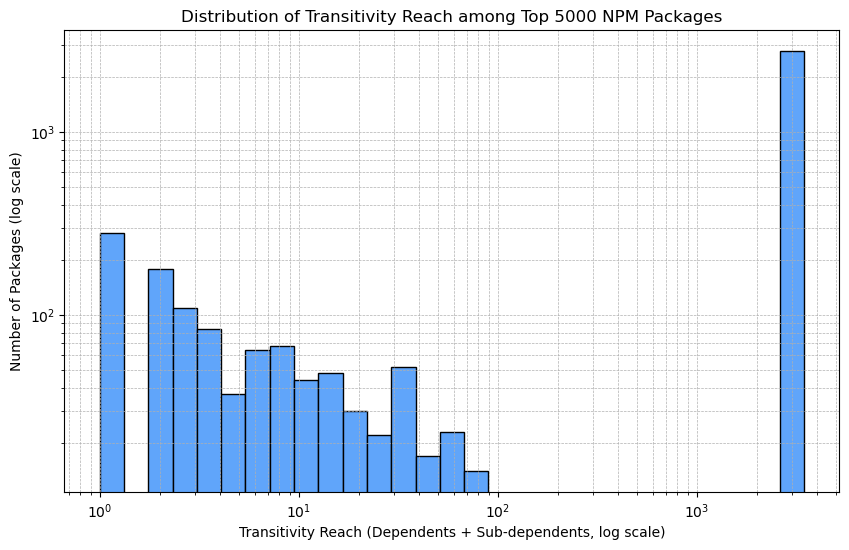

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# load the reach data
reach = pd.read_csv("transitivity_reach_top5000.csv")

# filter out zeros to avoid log(0)
reach_nonzero = reach[reach["transitive_reach"] > 0]

# make logarithmic bins to show skewed distribution properly
bins = np.logspace(
    np.log10(reach_nonzero["transitive_reach"].min()),
    np.log10(reach_nonzero["transitive_reach"].max()),
    30
)

# plot histogram with log scales on both axes
plt.figure(figsize=(10,6))
plt.hist(reach_nonzero["transitive_reach"], bins=bins, color="#60a5fa", edgecolor="black")
plt.xscale("log")
plt.yscale("log")

# label and style
plt.xlabel("Transitivity Reach (Dependents + Sub-dependents, log scale)")
plt.ylabel("Number of Packages (log scale)")
plt.title("Distribution of Transitivity Reach among Top 5000 NPM Packages")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

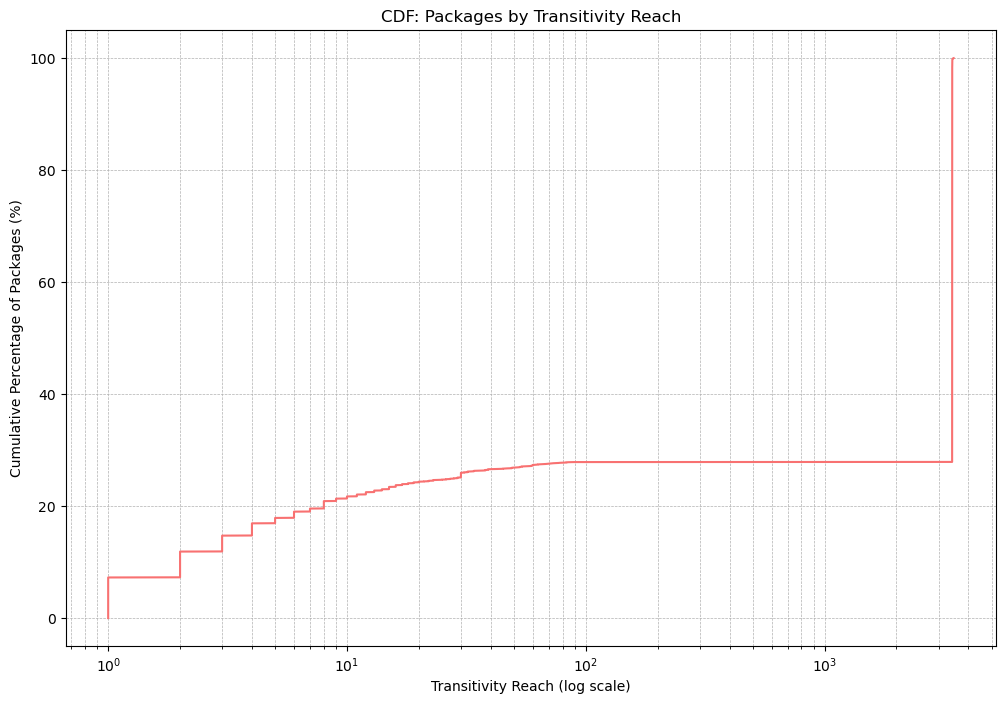

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# sort ascending
sorted_data = np.sort(reach_nonzero["transitive_reach"])

# compute cumulative percentage
yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100

# plot CDF
plt.figure(figsize=(12, 8))
plt.xscale("log")
plt.plot(sorted_data, yvals, color="#f87171")

# label and style
plt.xlabel("Transitivity Reach (log scale)")
plt.ylabel("Cumulative Percentage of Packages (%)")
plt.title("CDF: Packages by Transitivity Reach")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()